In [1]:
import pandas as pd
import os
import matplotlib.pyplot as plt
import numpy as np
import torch
import torch.nn as nn
from sklearn.metrics import r2_score, mean_absolute_error, mean_squared_error
from sklearn.model_selection import train_test_split
from torch.utils.data import DataLoader, TensorDataset
import tensorflow as tf
from xgboost import XGBRegressor
from tensorflow import keras
from scipy.interpolate import interpn
from tqdm import tqdm

In [2]:
from load_data import process_steel_data

full_path = 'data/'
path = 'data/MDC_Data_Descriptions_MeCoMeP-r-value.xlsx'
correlation_rate = 0.2
dvl_line = 1

df = process_steel_data(full_path, path, correlation_rate, dvl_line, model_output=True)
df = pd.get_dummies(df, columns=['steel_family'], prefix='steel').drop(['steel_grade'], axis=1)

c:\Users\A070050\AppData\Local\Programs\Python\Python38\lib\site-packages\openpyxl\worksheet\_reader.py:329: UserWarning: Data Validation extension is not supported and will be removed
  warn(msg)


Dropped 25 columns


In [3]:
from sklearn.preprocessing import StandardScaler

train_df, test_df = train_test_split(df, test_size=0.2, random_state=42)

# Identify binary columns (one-hot encoded)
binary_columns = [col for col in df.columns if col.startswith('steel_')]

# Identify columns to scale (non-binary columns)
columns_to_scale = [col for col in df.columns if col not in binary_columns + ['steel_grade']]

scaler = StandardScaler()
train_scaled = scaler.fit_transform(train_df[columns_to_scale])
test_scaled = scaler.transform(test_df[columns_to_scale])

train_scaled_df = pd.DataFrame(train_scaled, columns=columns_to_scale)
test_scaled_df = pd.DataFrame(test_scaled, columns=columns_to_scale)

for col in binary_columns:
    train_scaled_df[col] = train_df[col].values
    test_scaled_df[col] = test_df[col].values

In [4]:
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import RandomForestRegressor

def optimize_hyperparameters_rfr(X_train, y_train):
    param_grid = {
        'n_estimators': [100, 150, 200, 350, 300],
    }
    grid_search = GridSearchCV(
        estimator=RandomForestRegressor(random_state=42),
        param_grid=param_grid,
        cv=5,
        scoring='neg_mean_absolute_error',
        n_jobs=-1
    )
    grid_search.fit(X_train, y_train)
    return {
        'best_params': grid_search.best_params_,
        'best_estimator': grid_search.best_estimator_,
        'best_score': -grid_search.best_score_
    }

def train_optimized_model(df, model_type):

    X = df.drop(['r_value'] if 'steel_grade' in df.columns else ['r_value'], axis=1)
    y = df['r_value']
    
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
    
    # Train model based on type
    if model_type == 'rfr':
        optimization_results = optimize_hyperparameters_rfr(X_train, y_train)
    elif model_type == 'xgb':
        optimization_results = optimize_hyperparameters_xgb(X_train, y_train)
    elif model_type == 'gpr':
        optimization_results = optimize_hyperparameters_gpr(X_train, y_train)
    elif model_type == 'knn':
        optimization_results = optimize_hyperparameters_knn(X_train, y_train)
    elif model_type == 'svr':
        optimization_results = optimize_hyperparameters_svr(X_train, y_train)
    elif model_type == 'ridge':
        optimization_results = optimize_hyperparameters_ridge(X_train, y_train)
    else:
        raise ValueError(f"Unsupported model type: {model_type}")
    
    # Get best model and make predictions
    best_model = optimization_results['best_estimator']
    best_model.fit(X_train, y_train)
    y_pred_train = best_model.predict(X_train)
    y_pred_test = best_model.predict(X_test)
      
    results = {
        'model': best_model,
        'best_params': optimization_results['best_params'],
        'best_score': optimization_results['best_score'],
        'train_mse': mean_squared_error(y_train, y_pred_train),
        'val_mse': mean_squared_error(y_test, y_pred_test),
        'train_mae': mean_absolute_error(y_train, y_pred_train),
        'val_mae': mean_absolute_error(y_test, y_pred_test),
        'train_r2': r2_score(y_train, y_pred_train),
        'val_r2': r2_score(y_test, y_pred_test)
    }
    
    return results

In [7]:
# Run optimization
model_info = train_optimized_model(train_scaled_df, model_type='rfr')

print(f"Best Parameters: {model_info['best_params']}")
print(f"Best CV Score (MSE): {model_info['best_score']}")
print(f"VAL MAE: {model_info['val_mae']}")
print(f"VAL R2: {model_info['val_r2']}")

Best Parameters: {'n_estimators': 300}
Best CV Score (MSE): 0.152659978351588
VAL MAE: 0.14910189102972576
VAL R2: 0.9567331327438449


In [8]:
model_info

{'model': RandomForestRegressor(n_estimators=300, random_state=42),
 'best_params': {'n_estimators': 300},
 'best_score': 0.152659978351588,
 'train_mse': 0.0059712189418461665,
 'val_mse': 0.042567533545394096,
 'train_mae': 0.05537481716629632,
 'val_mae': 0.14910189102972576,
 'train_r2': 0.9940520752222363,
 'val_r2': 0.9567331327438449}

In [16]:
def tol90(y_true, y_pred):
    errors = np.abs(y_true - y_pred)
    return np.percentile(errors, 90)

def density_scatter(x, y, bins=30, **kwargs):
    """Create a density scatter plot"""
    # Ensure inputs are 1D arrays
    x = np.asarray(x).flatten()
    y = np.asarray(y).flatten()
    data, x_e, y_e = np.histogram2d(x, y, bins=bins)
    z = interpn((0.5*(x_e[1:] + x_e[:-1]), 0.5*(y_e[1:] + y_e[:-1])),
                data.T/data.max(),
                np.vstack([x,y]).T,
                method="splinef2d",
                bounds_error=False)
    z[np.where(np.isnan(z))] = 0.0
    idx = z.argsort()
    x, y, z = x[idx], y[idx], z[idx]
    plt.scatter(x, y, c=z, **kwargs)

def plot_predicted_vs_actual(model, df, features_dict=None, model_type=None, target_column='r_value', title=None, figsize=(10, 8)):
    plt.figure(figsize=figsize)
    
    # Get actual values
    actual = df[target_column].values
    
    # Get predictions based on model type
    if model_type == 'pytorch_mlp':
        # Prepare feature arrays for PyTorch MLP
        feature_arrays = {}
        for category in features_dict.keys():
            available_features = [col for col in features_dict[category] 
                                if col in df.columns]
            if available_features:
                scaler = StandardScaler()
                feature_arrays[category] = scaler.fit_transform(df[available_features].values)
            else:
                feature_arrays[category] = np.zeros((len(df), 0))
        
        # Convert features to tensors
        input_tensors = {
            category: torch.FloatTensor(arr) for category, arr in feature_arrays.items()
        }
        
        # Make predictions
        model.eval()
        with torch.no_grad():
            predicted = model(**input_tensors).numpy().flatten()
            
    elif model_type == 'keras':
        X = df.drop([target_column], axis=1).values
        X = X.astype('float32')
        predicted = model.predict(X).flatten()
        
    else:  # sklearn
        X = df.drop([target_column], axis=1)
        predicted = model['model'].predict(X)
    
    # Calculate metrics
    r2 = r2_score(actual, predicted)
    mse = mean_squared_error(actual, predicted)
    mae = mean_absolute_error(actual, predicted)
    tol90_value = tol90(actual, predicted)
    
    # Create density scatter plot
    density_scatter(actual, predicted, bins=30, alpha=0.6)
    
    # Plot perfect prediction line
    min_val = min(actual.min(), predicted.min())
    max_val = max(actual.max(), predicted.max())
    plt.plot([min_val, max_val], [min_val, max_val], 'r--', lw=2, label='Perfect Prediction')
    
    # Plot tolerance lines
    plt.plot([min_val, max_val], [min_val + tol90_value, max_val + tol90_value],
             'g--', lw=1.5, label=f'+tol90 ({tol90_value:.4f})')
    plt.plot([min_val, max_val], [min_val - tol90_value, max_val - tol90_value],
             'b--', lw=1.5, label=f'-tol90 ({tol90_value:.4f})')
    
    # Set plot limits with buffer
    buffer = 0.2
    x_min = actual.min() - (actual.max() - actual.min()) * buffer
    x_max = actual.max() + (actual.max() - actual.min()) * buffer
    y_min = predicted.min() - (predicted.max() - predicted.min()) * buffer
    y_max = predicted.max() + (predicted.max() - predicted.min()) * buffer
    plt.xlim(x_min, x_max)
    plt.ylim(y_min, y_max)
    
    # Annotate with metrics
    plt.text(0.05, 0.95,
             f"R²: {r2:.4f}\n" +
             f"MSE: {mse:.4f}\n" +
             f"MAE: {mae:.4f}\n" +
             f"tol90: {tol90_value:.4f}",
             transform=plt.gca().transAxes,
             verticalalignment='top',
             bbox=dict(facecolor='white', alpha=0.8))
    
    # Labeling
    plt.xlabel('Actual Value')
    plt.ylabel('Predicted Value')
    if title is None:
        title = f'Predicted vs Actual {target_column}'
    plt.title(title)
    plt.legend(loc='lower right')
    plt.grid(True, alpha=0.3)
    plt.axis('equal')
    plt.tight_layout()
    plt.show()
    
    return {
        'R2': r2,
        'MSE': mse,
        'MAE': mae,
        'tol90': tol90_value
    }

{'R2': 0.9575904491557501,
 'MSE': 0.042196411088404086,
 'MAE': 0.1494467211582525,
 'tol90': 0.34050708765634463}

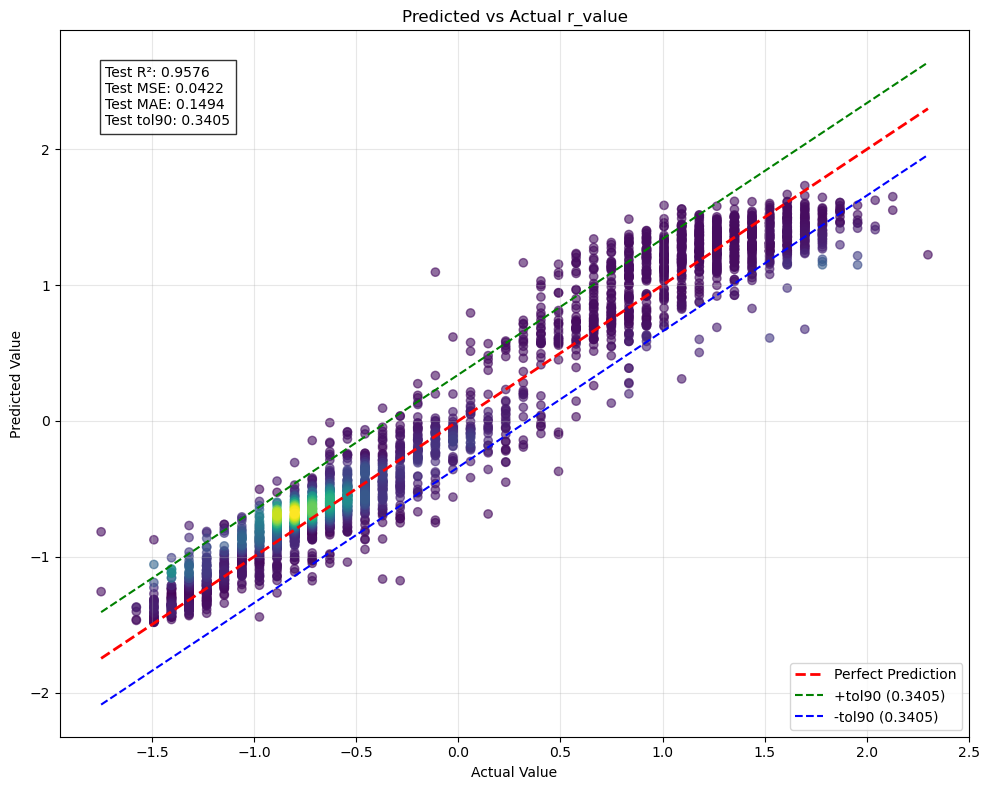

In [10]:
plot_predicted_vs_actual(model_info, test_scaled_df)

XGB -----

In [11]:
def optimize_hyperparameters_xgb(X_train, y_train):

    param_grid = {
        'eta': [0.01, 0.1, 0.3],
        'lambda': [0, 0.1, 1, 10],
        'max_depth': [3, 4, 5, 6]
    }
    
    grid_search = GridSearchCV(
        estimator=XGBRegressor(random_state=42),
        param_grid=param_grid,
        cv=5,  # 5-fold cross-validation
        scoring='neg_mean_absolute_error',
        n_jobs=-1  # Use all available cores
    )
    
    grid_search.fit(X_train, y_train)
    
    return {
        'best_params': grid_search.best_params_,
        'best_estimator': grid_search.best_estimator_,
        'best_score': -grid_search.best_score_
    }

In [12]:
trained_models_xgb = train_optimized_model(train_scaled_df, model_type='xgb')

{'R2': 0.9555866919694271,
 'MSE': 0.04419009789414144,
 'MAE': 0.155763582711918,
 'tol90': 0.34122445909398547}

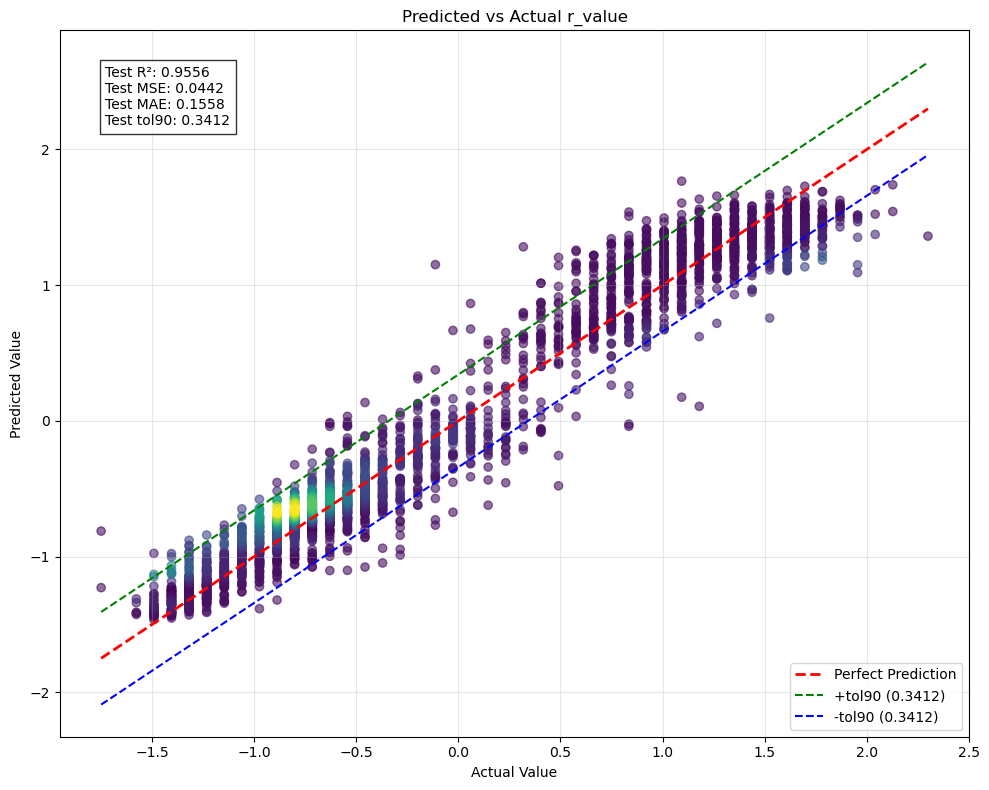

In [13]:
plot_predicted_vs_actual(trained_models_xgb, test_scaled_df)

ANN---- (from Millner paper)

In [14]:
class SteelPropertiesANN:
    def __init__(self, input_dim, target_column):
        self.input_dim = input_dim
        self.target_column = target_column
        self.best_model = None
        self.best_params = None
        self.best_score = float('inf')

    def build_model(self, config):
        hidden_layers = config['layers']
        learning_rate = config['learning_rate']
        l2_strength = config['l2_regularization']
        
        model = keras.Sequential()
        model.add(keras.layers.Input(shape=(self.input_dim,)))
        
        for units, activation in hidden_layers:
            model.add(keras.layers.Dense(
                units=units,
                activation=activation,
                kernel_regularizer=keras.regularizers.l2(l2_strength)
            ))
        
        model.add(keras.layers.Dense(1))
        
        lr_schedule = keras.optimizers.schedules.ExponentialDecay(
            initial_learning_rate=learning_rate,
            decay_steps=100,
            decay_rate=0.9,
            staircase=True
        )
        
        model.compile(
            optimizer=keras.optimizers.Adam(learning_rate=lr_schedule, clipnorm=1.0),
            loss='mean_absolute_error',
            metrics=['mae', 'mse']
        )
        return model

    def generate_grid_configs(self, 
        layer_options=[(64, 'relu'), (128, 'relu'), (256, 'relu')],
        layer_depths=[2, 3, 4],
        learning_rates=[1e-2, 1e-3, 1e-4],
        l2_regularization=[1e-3, 1e-4, 1e-5],
        batch_sizes=[16, 32, 64]
    ):
        from itertools import product
        grid_configs = []
        
        for depth in layer_depths:
            for lr in learning_rates:
                for l2_reg in l2_regularization:
                    for batch_size in batch_sizes:
                        layer_combinations = list(product(layer_options, repeat=depth))
                        for layers in layer_combinations:
                            config = {
                                'layers': layers,
                                'learning_rate': lr,
                                'l2_regularization': l2_reg,
                                'batch_size': batch_size
                            }
                            grid_configs.append(config)
        
        return grid_configs

    def grid_search(self, train_scaled_df, grid_configs=None, epochs=100, max_configs=None):
        # Split training data into training and validation sets
        train_data, val_data = train_test_split(train_scaled_df, test_size=0.2, random_state=42)
    
        if grid_configs is None:
            grid_configs = self.generate_grid_configs()
        
        X_train = train_data.drop([self.target_column], axis=1)
        y_train = train_data[self.target_column]
        X_val = val_data.drop([self.target_column], axis=1)
        y_val = val_data[self.target_column]
        
        if max_configs:
            grid_configs = grid_configs[:max_configs]
        
        results = []
        for config in tqdm(grid_configs, desc="Training models"):
            tf.keras.backend.clear_session()
            model = self.build_model(config)
            batch_size = min(config['batch_size'], len(X_train))
            
            early_stopping = keras.callbacks.EarlyStopping(
                monitor='val_loss', 
                patience=10, 
                restore_best_weights=True,
                min_delta=1e-4
            )
            
            try:
                X_train = np.array(X_train, dtype=np.float32)
                y_train = np.array(y_train, dtype=np.float32)
                X_val = np.array(X_val, dtype=np.float32)
                y_val = np.array(y_val, dtype=np.float32)

                train_dataset = tf.data.Dataset.from_tensor_slices((X_train, y_train))
                train_dataset = (train_dataset
                    .batch(batch_size, drop_remainder=False)
                    .repeat())
                
                val_dataset = tf.data.Dataset.from_tensor_slices((X_val, y_val))
                val_dataset = val_dataset.batch(batch_size)
                
                steps_per_epoch = len(X_train) // batch_size
                
                history = model.fit(
                    train_dataset,
                    validation_data=val_dataset,
                    epochs=epochs,
                    steps_per_epoch=steps_per_epoch,
                    callbacks=[early_stopping],
                    verbose=0
                )
                
                val_loss = model.evaluate(X_val, y_val, verbose=0)[0]
                
                result_entry = config.copy()
                result_entry.update({'val_loss': val_loss})
                results.append(result_entry)
                
                if val_loss < self.best_score:
                    self.best_score = val_loss
                    self.best_model = model
                    self.best_params = config
                
            except Exception as e:
                print(f"Error with config {config}: {str(e)}")
                continue
        
        return self.best_model, self.best_params

    def evaluate(self, test_scaled_df):
        if self.best_model is None:
            raise ValueError("No model has been trained. Call grid_search first.")
        
        X_test = test_scaled_df.drop([self.target_column], axis=1)
        y_test = test_scaled_df[self.target_column]
        
        y_pred = self.best_model.predict(X_test).flatten()
        
        # Calculate metrics
        mse = mean_squared_error(y_test, y_pred)
        mae = mean_absolute_error(y_test, y_pred)
        r2 = r2_score(y_test, y_pred)
        tol90_value = tol90(y_test, y_pred)
        
        # Create visualization
        plt.figure(figsize=(10, 8))
        plot_single_comparison(y_test, y_pred, "All Families", r2, mse, mae, tol90_value)
        plt.tight_layout()
        plt.show()
        
        return {
            'model': self.best_model,
            'MSE': mse,
            'MAE': mae,
            'R2': r2,
            'tol90': tol90_value,
            'Best Parameters': self.best_params
        }

: 

In [ ]:
# Create the ANN instance
ann = SteelPropertiesANN(
    input_dim=train_scaled_df.drop(['r_value'], axis=1).shape[1],
    target_column='r_value'
)

configs = ann.generate_grid_configs(
    layer_options=[(64, 'relu'), (128, 'relu'), (256, 'relu')],
    layer_depths=[2, 3, 4],
    learning_rates=[1e-3, 1e-4],
    l2_regularization=[1e-3, 1e-4],
    batch_sizes=[16, 32, 64]
)

best_model, best_params = ann.grid_search(train_scaled_df, grid_configs=configs)

# Evaluate and visualize
metrics = ann.evaluate(test_scaled_df)
print("Best Model Metrics:")
print(metrics)

best_model.save('model_mecomep.h5')

Training models:   9%|▉         | 130/1404 [20:05<4:31:27, 12.78s/it]

In [ ]:
# best_params = {'layers': ((256, 'relu'), (64, 'relu')),
#  'learning_rate': 0.001,
#  'l2_regularization': 0.0001,
#  'batch_size': 64}

model_ann = keras.models.load_model('model_mecomep.h5')

ValueError: Argument(s) not recognized: {'jit_compile': False, 'is_legacy_optimizer': False}

97/97 ━━━━━━━━━━━━━━━━━━━━ 0s 523us/step


{'R2': 0.9364693282738193,
 'MSE': 0.0632113825191299,
 'MAE': 0.18007310168203394,
 'tol90': 0.40310215719934606}

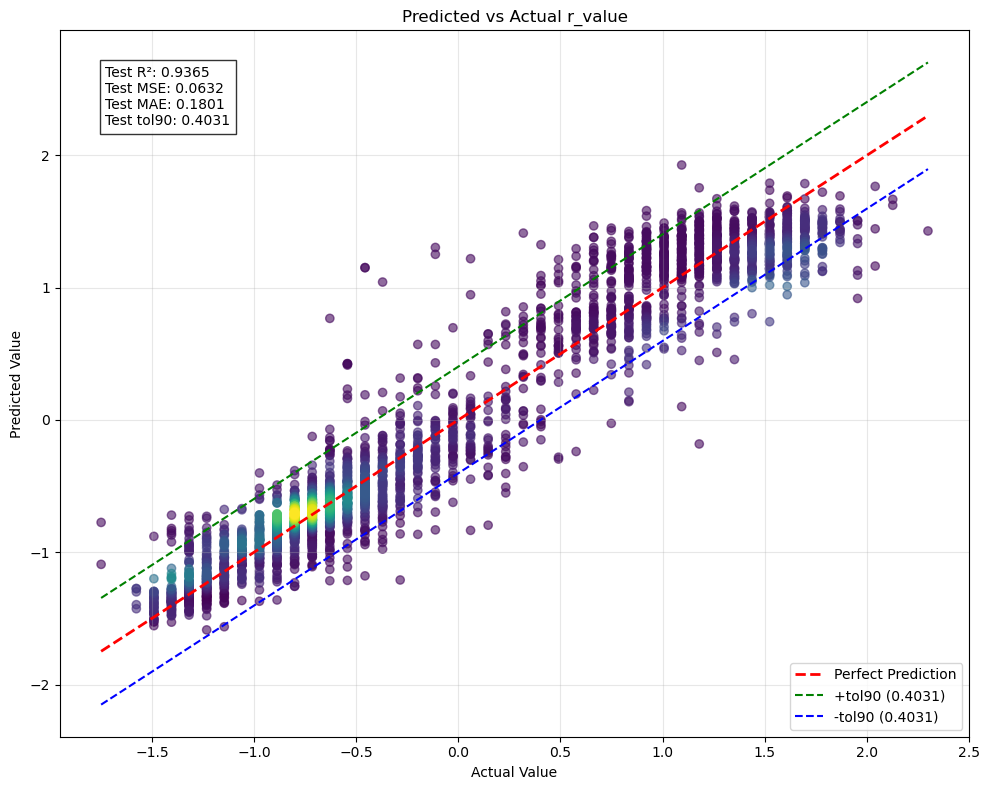

In [ ]:
plot_predicted_vs_actual(model_ann, test_scaled_df)

GPR ------

In [ ]:
from sklearn.gaussian_process.kernels import ConstantKernel, Matern, WhiteKernel
from sklearn.gaussian_process import GaussianProcessRegressor

def optimize_hyperparameters_gpr(X_train, y_train):

    
    # Define the parameter grid
    param_grid = {
        'kernel': [
            ConstantKernel(constant_value=1.0, constant_value_bounds=(1e-2, 1e2)) * 
            Matern(length_scale=1.0, length_scale_bounds=(1e-2, 1e2), nu=1.5) + 
            WhiteKernel(noise_level=1.0, noise_level_bounds=(1e-5, 1e1))
        ]
    }
    
    gpr = GaussianProcessRegressor(normalize_y=True)
    
    # Grid search for the best hyperparameters
    grid_search = GridSearchCV(
        estimator=gpr,
        param_grid=param_grid,
        cv=5,
        scoring='neg_mean_absolute_error',
        n_jobs=-1
    )
    
    grid_search.fit(X_train, y_train)
    
    return {
        'best_params': grid_search.best_params_,
        'best_estimator': grid_search.best_estimator_,
        'best_score': -grid_search.best_score_
    }


In [ ]:
trained_models_gpr = train_optimized_model(train_scaled_df, 'gpr')

{'R2': 0.940498904530411,
 'MSE': 0.0592020579011998,
 'MAE': 0.1762977421082072,
 'tol90': 0.38628006102153506}

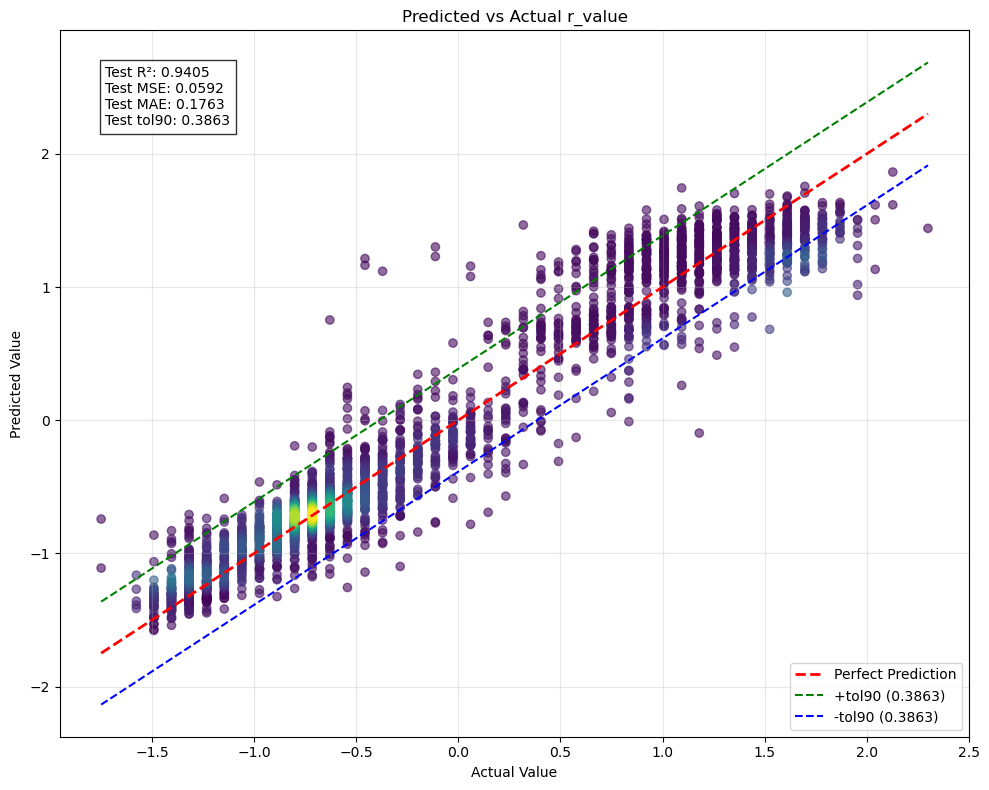

In [ ]:
plot_predicted_vs_actual(trained_models_gpr, test_scaled_df)

KNN -----

In [ ]:
from sklearn.neighbors import KNeighborsRegressor

def optimize_hyperparameters_knn(X_train, y_train):
    param_grid = {
        'n_neighbors': [3, 5, 7, 9, 11],  # Number of neighbors to use
        'leaf_size': [20, 30, 40, 50],    # Leaf size passed to BallTree or KDTree
        'weights': ['uniform', 'distance']  # Weight function used in prediction
    }
    
    # Initialize the KNN regressor
    knn = KNeighborsRegressor()
    
    # Set up GridSearchCV
    grid_search = GridSearchCV(
        estimator=knn,
        param_grid=param_grid,
        cv=5,  # 5-fold cross-validation
        scoring='neg_mean_absolute_error',
        n_jobs=-1  # Use all available cores
    )
    
    # Fit the model
    grid_search.fit(X_train, y_train)
    
    # Return the best parameters, estimator, and score
    return {
        'best_params': grid_search.best_params_,
        'best_estimator': grid_search.best_estimator_,
        'best_score': -grid_search.best_score_
    }

{'R2': 0.9332973716407997,
 'MSE': 0.06636739769441521,
 'MAE': 0.18483594473670553,
 'tol90': 0.4161785900761575}

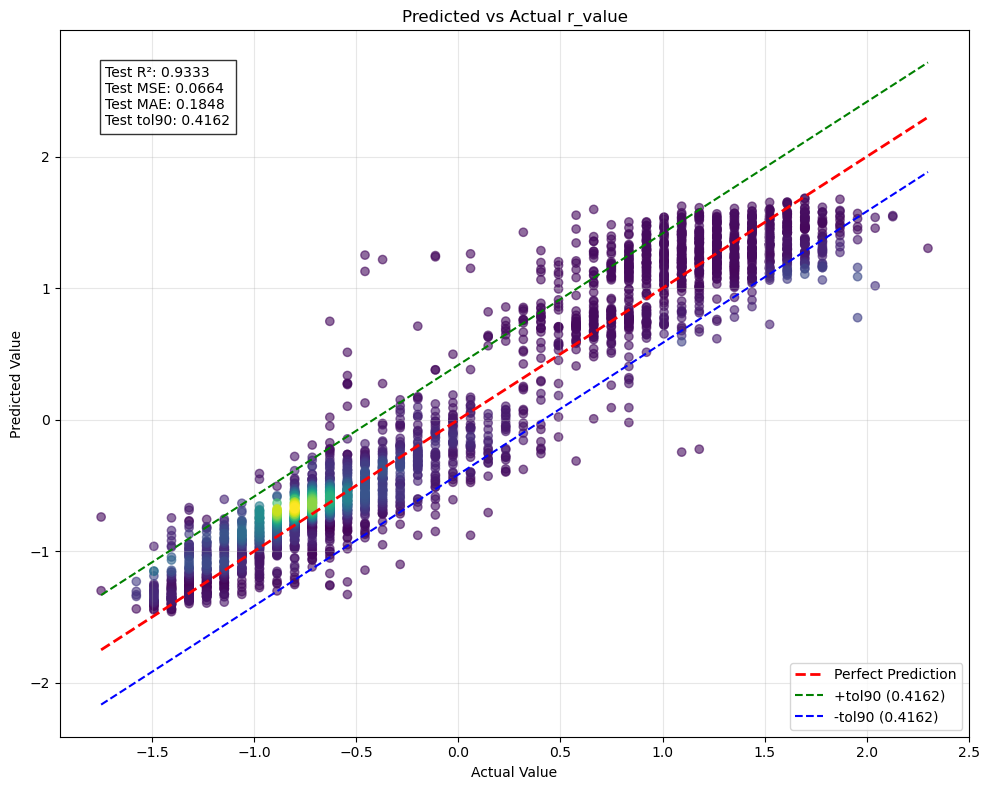

In [ ]:
trained_models_knn = train_optimized_model(train_scaled_df, 'knn')
plot_predicted_vs_actual(trained_models_knn, test_scaled_df)

SVR ----

In [ ]:
from sklearn.svm import SVR

def optimize_hyperparameters_svr(X_train, y_train):
    # Define the parameter grid
    param_grid = {
        'C': [0.1, 1, 10, 100],        # Regularization parameter
        'epsilon': [0.01, 0.1, 0.5, 1] # Epsilon in the epsilon-SVR model
    }
    
    # Initialize the SVR model
    svr = SVR(kernel='rbf')
    
    # Set up GridSearchCV
    grid_search = GridSearchCV(
        estimator=svr,
        param_grid=param_grid,
        cv=5,
        scoring='neg_mean_absolute_error',
        n_jobs=-1
    )
    
    # Fit the model
    grid_search.fit(X_train, y_train)
    
    # Return the best parameters, estimator, and score
    return {
        'best_params': grid_search.best_params_,
        'best_estimator': grid_search.best_estimator_,
        'best_score': -grid_search.best_score_
    }

{'R2': 0.9377914255433754,
 'MSE': 0.06189592977854506,
 'MAE': 0.17742747012557605,
 'tol90': 0.40054608835422856}

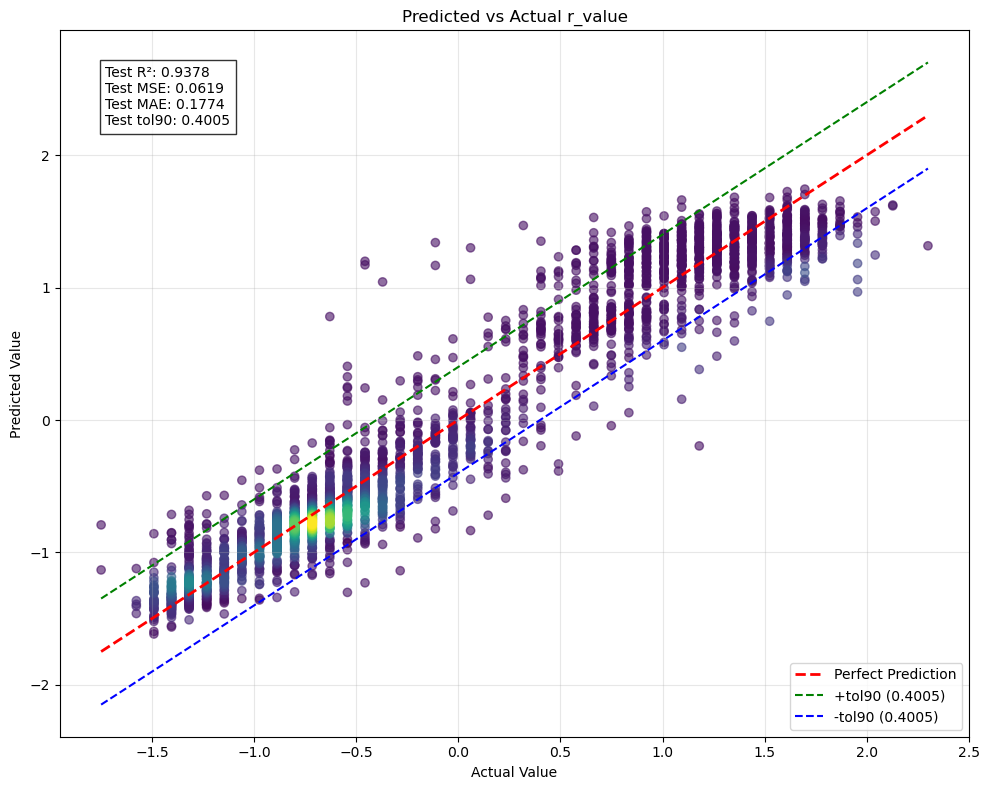

In [ ]:
trained_models_svr = train_optimized_model(train_scaled_df, 'svr')
plot_predicted_vs_actual(trained_models_svr, test_scaled_df)

In [ ]:
from sklearn.linear_model import RidgeCV

def optimize_hyperparameters_ridge(X_train, y_train):
    # Define the range of alpha values to test
    alphas = [0.1, 1.0, 10.0, 100.0]
    
    # Initialize the RidgeCV model with the specified alphas
    ridge_cv = RidgeCV(alphas=alphas, store_cv_values=True)
    
    # Fit the model to the training data
    ridge_cv.fit(X_train, y_train)
    
    # Retrieve the best alpha and the corresponding model
    best_alpha = ridge_cv.alpha_
    best_model = ridge_cv
    
    # Calculate the mean cross-validated score for the best alpha
    best_score = -ridge_cv.cv_values_.mean()
    
    return {
        'best_params': {'alpha': best_alpha},
        'best_estimator': best_model,
        'best_score': best_score
    }

{'R2': 0.9204769125018226,
 'MSE': 0.07912342442426945,
 'MAE': 0.21316156964460906,
 'tol90': 0.4456957580634152}

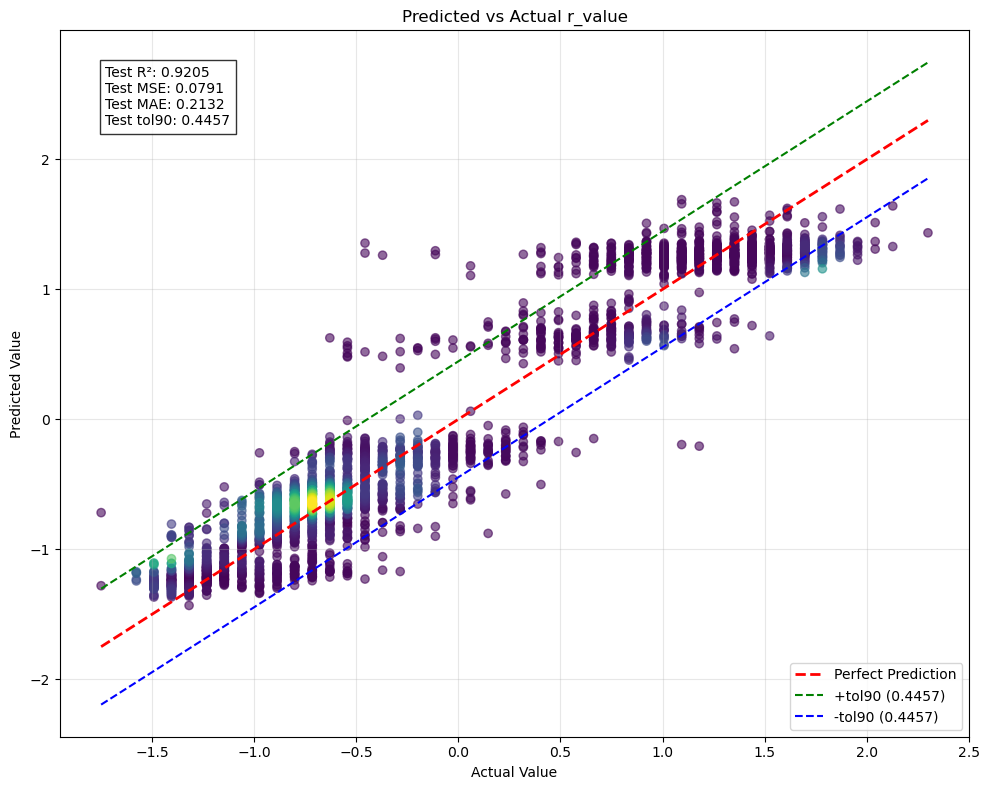

In [ ]:
trained_models_ridge = train_optimized_model(train_scaled_df, 'ridge')
plot_predicted_vs_actual(trained_models_ridge, test_scaled_df)

In [ ]:
from sklearn.linear_model import RidgeCV

def optimize_hyperparameters_ridge(X_train, y_train):
    # Define the range of alpha values to test
    alphas = [0.1, 1.0, 10.0, 100.0]
    
    # Initialize the RidgeCV model with the specified alphas
    ridge_cv = RidgeCV(alphas=alphas, store_cv_values=True)
    
    # Fit the model to the training data
    ridge_cv.fit(X_train, y_train)
    
    # Retrieve the best alpha and the corresponding model
    best_alpha = ridge_cv.alpha_
    best_model = ridge_cv
    
    # Calculate the mean cross-validated score for the best alpha
    best_score = -ridge_cv.cv_values_.mean()
    
    return {
        'best_params': {'alpha': best_alpha},
        'best_estimator': best_model,
        'best_score': best_score
    }

In [ ]:
trained_models_ridge = train_optimized_model(train_scaled_df, 'ridge')
plot_predicted_vs_actual(trained_models_ridge, test_scaled_df)

In [5]:
# labeling the features for each branch
features = [col for col in df.columns if col not in ['r_value', 'steel_family', 'steel_grade']]
features_dict = {
   'time': [col for col in features if 'time' in col.lower()], 
   'chemical': ['pct_al', 'pct_b', 'pct_c', 'pct_cr', 'pct_mn', 'pct_n', 'pct_nb', 'pct_si', 'pct_ti', 'pct_v', 'mfia_coil_frac_fer', 'mfia_et1_frac_fer', 'mfia_et2_frac_fer'],
   'model': ["rm", "ag", "a80", "n_value"]
}
features_dict['process'] = [col for col in features if col not in features_dict['time'] and col not in features_dict['chemical'] and col not in features_dict['model']]

In [6]:
class MultiBranchSteelRegressor(nn.Module):
    def __init__(self, chemical_dim, time_dim, process_dim, model_dim, hidden_units=64, dropout_rate=0.2):
        super().__init__()
        # Track which branches are active
        self.has_chemical = chemical_dim > 0
        self.has_time = time_dim > 0
        self.has_process = process_dim > 0
        self.has_model = model_dim > 0
        
        # Count active branches
        self.active_branches = sum([self.has_chemical, self.has_time, self.has_process, self.has_model])
        
        # Adjust hidden units for each branch
        self.branch_hidden = min(hidden_units, max(16, hidden_units // 2))
        
        # Creating branch
        def create_branch(input_dim):
            return nn.Sequential(
                nn.Linear(input_dim, self.branch_hidden),
                nn.BatchNorm1d(self.branch_hidden),
                nn.ReLU(),
                nn.Dropout(dropout_rate)
            )
        
        # Only create branches that have features
        if self.has_chemical:
            self.chemical_branch = create_branch(chemical_dim)
        if self.has_time:
            self.time_branch = create_branch(time_dim)
        if self.has_process:
            self.process_branch = create_branch(process_dim)
        if self.has_model:
            self.model_branch = create_branch(model_dim)
        
        # Combined input dimension based on active branches only
        combined_dim = self.branch_hidden * self.active_branches
        
        # Final layers after concatenation
        self.final_layers = nn.Sequential(
            nn.Linear(combined_dim, 128),
            nn.BatchNorm1d(128),
            nn.ReLU(),
            nn.Dropout(dropout_rate),
            nn.Linear(128, 64),
            nn.BatchNorm1d(64),
            nn.ReLU(),
            nn.Dropout(dropout_rate),
            nn.Linear(64, 1)
        )
    
    def forward(self, chemical, time, process, model):
        features = []
        # Only process branches that have features
        if self.has_chemical:
            if chemical.dim() == 1:
                chemical = chemical.unsqueeze(0)
            features.append(self.chemical_branch(chemical))
        
        if self.has_time:
            if time.dim() == 1:
                time = time.unsqueeze(0)
            features.append(self.time_branch(time))
        
        if self.has_process:
            if process.dim() == 1:
                process = process.unsqueeze(0)
            features.append(self.process_branch(process))
        
        if self.has_model:
            if model.dim() == 1:
                model = model.unsqueeze(0)
            features.append(self.model_branch(model))
        
        # Concatenate only active features
        combined = torch.cat(features, dim=1) if len(features) > 1 else features[0]
        return self.final_layers(combined)

In [7]:
class EnhancedMultiBranchRegressor(nn.Module):
    def __init__(self, chemical_dim, time_dim, process_dim, model_dim=None, hyperparameters=None):
        super().__init__()

        default_params = {
            'batch_size': 32,
            'hidden_units': 64,
            'dropout_rate': 0.2,
            'cross_branch_dropout': 0,
            'final_layer_units': [128, 64],
            'final_layer_dropout': [0, 0],
            'activation': nn.ReLU(),
            'normalization': 'layer',
            'l2_lambda': 0.001,
            'residual_blocks': 2  # Number of residual blocks per branch
        }
        # Merge default and provided hyperparameters
        self.hp = {**default_params, **(hyperparameters or {})}

        def get_normalization(units):
            """Select normalization layer based on configuration."""
            if self.hp['normalization'] == 'batch':
                return nn.BatchNorm1d(units)
            elif self.hp['normalization'] == 'layer':
                return nn.LayerNorm(units)
            else:
                return nn.Identity()

        def create_residual_block(input_dim):
            """Create a residual block with adaptive configuration."""
            return ResidualBlock(
                input_dim, 
                self.hp['hidden_units'], 
                activation=self.hp['activation'], 
                dropout_rate=self.hp['dropout_rate'],
                normalization_func=get_normalization
            )

        def create_residual_branch(input_dim):
            """Create a residual branch with multiple blocks."""
            if input_dim <= 0:
                return None
            
            blocks = []
            # Initial projection layer
            blocks.append(nn.Linear(input_dim, self.hp['hidden_units']))
            blocks.append(get_normalization(self.hp['hidden_units']))
            blocks.append(self.hp['activation'])

            # Add residual blocks
            for _ in range(self.hp['residual_blocks']):
                blocks.append(create_residual_block(self.hp['hidden_units']))
            
            return nn.Sequential(*blocks)

        # Residual Branches
        self.branches = nn.ModuleDict({
            'chemical': create_residual_branch(chemical_dim),
            'time': create_residual_branch(time_dim),
            'process': create_residual_branch(process_dim),
            'model': create_residual_branch(model_dim)
        })

        # Cross-branch interaction
        active_branches = sum(1 for branch in self.branches.values() if branch is not None)
        cross_input_dim = self.hp['hidden_units'] * active_branches

        # Cross-branch interaction with residual connection
        self.cross_branch_interaction = nn.Sequential(
            nn.Linear(cross_input_dim, cross_input_dim // 2),
            self.hp['activation'],
            nn.Dropout(self.hp['cross_branch_dropout'])
        )

        # Dynamic final layers based on hyperparameters
        final_layers = []
        prev_units = cross_input_dim // 2
        for units, dropout_rate in zip(self.hp['final_layer_units'], self.hp['final_layer_dropout']):
            final_layers.extend([
                nn.Linear(prev_units, units),
                get_normalization(units),
                self.hp['activation'],
                nn.Dropout(dropout_rate)
            ])
            prev_units = units
        final_layers.append(nn.Linear(prev_units, 1))
        self.final_layers = nn.Sequential(*final_layers)

    def forward(self, chemical, time, process, model=None):
        processed_branches = []
        branch_inputs_and_names = [
            ('chemical', chemical, self.branches['chemical']),
            ('time', time, self.branches['time']),
            ('process', process, self.branches['process']),
            ('model', model, self.branches['model'])
        ]
        
        for name, input_tensor, branch in branch_inputs_and_names:
            if branch is not None and input_tensor is not None:
                processed_branches.append(branch(input_tensor))
        
        # Cross-branch interaction
        if len(processed_branches) > 1:
            cross_branch_features = torch.cat(processed_branches, dim=1)
            interaction_features = self.cross_branch_interaction(cross_branch_features)
        else:
            interaction_features = processed_branches[0]
        
        return self.final_layers(interaction_features)


# The ResidualBlock class remains unchanged
class ResidualBlock(nn.Module):
    def __init__(self, input_dim, hidden_dim, activation=nn.ReLU(), 
                 dropout_rate=0.2, normalization_func=None):
        super().__init__()
        
        # Use provided normalization function or default to Identity
        norm_func = normalization_func(hidden_dim) if normalization_func else nn.Identity()
        
        # Residual block with two linear layers
        self.block = nn.Sequential(
            nn.Linear(input_dim, hidden_dim),
            norm_func,
            activation,
            nn.Dropout(dropout_rate),
            nn.Linear(hidden_dim, hidden_dim),
            norm_func
        )
        
        # Shortcut connection
        if input_dim != hidden_dim:
            self.shortcut = nn.Linear(input_dim, hidden_dim)
        else:
            self.shortcut = nn.Identity()
        
        # Final activation
        self.activation = activation

    def forward(self, x):
        # Residual connection
        residual = self.shortcut(x)
        out = self.block(x)
        
        # Combine residual and transformed features
        combined = residual + out
        return self.activation(combined)

In [8]:
def train_model_regular(df, features_dict, num_epochs, hyperparameters, use_l2=False):
    batch_size = hyperparameters['batch_size']
    
    # Initialize feature arrays and dimensions
    feature_arrays = {}
    feature_dims = {}
    
    # Process each feature category
    for category in ['chemical', 'time', 'process', 'model']:
        available_features = [col for col in features_dict[category] 
                            if col in df.columns]
        
        if available_features:
            feature_arrays[category] = df[available_features].values.astype(np.float32)
            feature_dims[category] = len(available_features)
        else:
            feature_arrays[category] = np.zeros((len(df), 0), dtype=np.float32)
            feature_dims[category] = 0
    
    # Prepare targets
    targets = df['r_value'].values
    
    # Split data
    split_data = train_test_split(
        feature_arrays['chemical'],
        feature_arrays['time'],
        feature_arrays['process'],
        feature_arrays['model'],
        targets,
        test_size=0.2,
        random_state=42
    )
    
    (X_train_chem, X_test_chem, X_train_time, X_test_time, 
     X_train_proc, X_test_proc, X_train_model, X_test_model, 
     y_train, y_test) = split_data
    
    # Convert to tensors
    train_tensors = {
        'chemical': torch.FloatTensor(X_train_chem),
        'time': torch.FloatTensor(X_train_time),
        'process': torch.FloatTensor(X_train_proc),
        'model': torch.FloatTensor(X_train_model)
    }
    
    test_tensors = {
        'chemical': torch.FloatTensor(X_test_chem),
        'time': torch.FloatTensor(X_test_time),
        'process': torch.FloatTensor(X_test_proc),
        'model': torch.FloatTensor(X_test_model)
    }
    
    y_train_tensor = torch.FloatTensor(y_train)
    y_test_tensor = torch.FloatTensor(y_test)
    
    # Create DataLoader
    train_dataset = TensorDataset(
        train_tensors['chemical'],
        train_tensors['time'],
        train_tensors['process'],
        train_tensors['model'],
        y_train_tensor
    )
    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, drop_last=True)
    
    # Initialize model
    model = MultiBranchSteelRegressor(
        chemical_dim=feature_dims['chemical'],
        time_dim=feature_dims['time'],
        process_dim=feature_dims['process'],
        model_dim=feature_dims['model'],
        hidden_units=hyperparameters['hidden_units'],
        dropout_rate=hyperparameters['dropout_rate']
    )
    
    if use_l2:
        weight_decay = 0.001
    else:
        weight_decay = 0.0
    
    optimizer = torch.optim.AdamW(model.parameters(), weight_decay=weight_decay)
    criterion = nn.L1Loss()
    
    # Training loop
    model.train()
    for epoch in range(num_epochs):
        running_loss = 0.0
        for batch_chem, batch_time, batch_proc, batch_model, batch_targets in train_loader:
            optimizer.zero_grad()
            outputs = model(batch_chem, batch_time, batch_proc, batch_model)
            loss = criterion(outputs, batch_targets.unsqueeze(1))
            loss.backward()
            optimizer.step()
            running_loss += loss.item()
            
        if (epoch + 1) % 10 == 0:
            print(f"Epoch [{epoch+1}/{num_epochs}], Loss: {running_loss / len(train_loader):.4f}")
    
    # Evaluation
    model.eval()
    with torch.no_grad():
        y_pred = model(
            test_tensors['chemical'],
            test_tensors['time'],
            test_tensors['process'],
            test_tensors['model']
        )
        test_loss = criterion(y_pred, y_test_tensor.unsqueeze(1)).item()
        y_pred_np = y_pred.numpy().flatten()
        r2 = r2_score(y_test, y_pred_np)
        mae = mean_absolute_error(y_test, y_pred_np)
        mse = mean_squared_error(y_test, y_pred_np)
        
        metrics = {
            'r2_score': r2,
            'mae': mae,
            'mse': mse,
            'test_loss': test_loss
        }
        print(f"Evaluation - Test Loss: {test_loss:.4f}, R2: {r2:.4f}")
    
    return model, metrics

In [9]:
def train_model_enhanced(df, features_dict, num_epochs, hyperparameters, use_l2=False):
    batch_size = hyperparameters.get('batch_size', 32)
    
    # Initialize feature arrays and dimensions
    feature_arrays = {}
    feature_dims = {}
    
    # Process each feature category with explicit type conversion
    for category in ['chemical', 'time', 'process', 'model']:
        available_features = [col for col in features_dict[category] 
                            if col in df.columns]
        
        if available_features:
            # Convert to float type and handle any non-numeric values
            feature_data = df[available_features].apply(pd.to_numeric, errors='coerce').fillna(0)
            feature_arrays[category] = feature_data.values.astype(np.float32)
            feature_dims[category] = len(available_features)
        else:
            feature_arrays[category] = np.zeros((len(df), 0), dtype=np.float32)
            feature_dims[category] = 0
    
    # Prepare targets
    targets = df['r_value'].astype(np.float32).values
    
    # Split data
    split_data = train_test_split(
        feature_arrays['chemical'],
        feature_arrays['time'],
        feature_arrays['process'],
        feature_arrays['model'],
        targets,
        test_size=0.2,
        random_state=42
    )
    
    (X_train_chem, X_test_chem, X_train_time, X_test_time, 
     X_train_proc, X_test_proc, X_train_model, X_test_model, 
     y_train, y_test) = split_data
    
    # Convert to tensors
    train_tensors = {
        'chemical': torch.FloatTensor(X_train_chem),
        'time': torch.FloatTensor(X_train_time),
        'process': torch.FloatTensor(X_train_proc),
        'model': torch.FloatTensor(X_train_model)
    }
    
    test_tensors = {
        'chemical': torch.FloatTensor(X_test_chem),
        'time': torch.FloatTensor(X_test_time),
        'process': torch.FloatTensor(X_test_proc),
        'model': torch.FloatTensor(X_test_model)
    }
    
    y_train_tensor = torch.FloatTensor(y_train)
    y_test_tensor = torch.FloatTensor(y_test)
    
    # Create DataLoader
    train_dataset = TensorDataset(
        train_tensors['chemical'],
        train_tensors['time'],
        train_tensors['process'],
        train_tensors['model'],
        y_train_tensor
    )
    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, drop_last=True)
    
    # Initialize model
    model = EnhancedMultiBranchRegressor(
        chemical_dim=feature_dims['chemical'],
        time_dim=feature_dims['time'],
        process_dim=feature_dims['process'],
        model_dim=feature_dims['model'],
        hyperparameters=hyperparameters
    )
    
    if use_l2:
        weight_decay = 0.001
    else:
        weight_decay = 0.0
    
    optimizer = torch.optim.AdamW(model.parameters(), weight_decay=weight_decay)
    criterion = nn.L1Loss()
    
    # Training loop
    model.train()
    for epoch in range(num_epochs):
        running_loss = 0.0
        for batch_chem, batch_time, batch_proc, batch_model, batch_targets in train_loader:
            optimizer.zero_grad()
            outputs = model(batch_chem, batch_time, batch_proc, batch_model)
            loss = criterion(outputs, batch_targets.unsqueeze(1))
            loss.backward()
            optimizer.step()
            running_loss += loss.item()
            
        if (epoch + 1) % 10 == 0:
            print(f"Epoch [{epoch+1}/{num_epochs}], Loss: {running_loss / len(train_loader):.4f}")
    
    # Evaluation
    model.eval()
    with torch.no_grad():
        y_pred = model(
            test_tensors['chemical'],
            test_tensors['time'],
            test_tensors['process'],
            test_tensors['model']
        )
        test_loss = criterion(y_pred, y_test_tensor.unsqueeze(1)).item()
        y_pred_np = y_pred.numpy().flatten()
        r2 = r2_score(y_test, y_pred_np)
        mae = mean_absolute_error(y_test, y_pred_np)
        mse = mean_squared_error(y_test, y_pred_np)
        
        evaluation_results = {
            'test_loss': test_loss,
            'r2_score': r2,
            'mae': mae,
            'mse': mse
        }
        print(f"Evaluation - Test Loss: {test_loss:.4f}, R2: {r2:.4f}")
    
    return model, evaluation_results

In [10]:
num_epochs=100

best_params = {'batch_size': 32,
 'dropout_rate': 0.2,
 'hidden_units': 64,
 'learning_rate': 0.001,
 'l2_lambda': 0.001
}

In [13]:
best_mlp = train_model_regular(train_scaled_df, features_dict, num_epochs, best_params)

Epoch [10/100], Loss: 0.2371
Epoch [20/100], Loss: 0.2220
Epoch [30/100], Loss: 0.2150
Epoch [40/100], Loss: 0.2105
Epoch [50/100], Loss: 0.2070
Epoch [60/100], Loss: 0.2030
Epoch [70/100], Loss: 0.1987
Epoch [80/100], Loss: 0.1979
Epoch [90/100], Loss: 0.1949
Epoch [100/100], Loss: 0.1965
Evaluation - Test Loss: 0.1679, R2: 0.9481


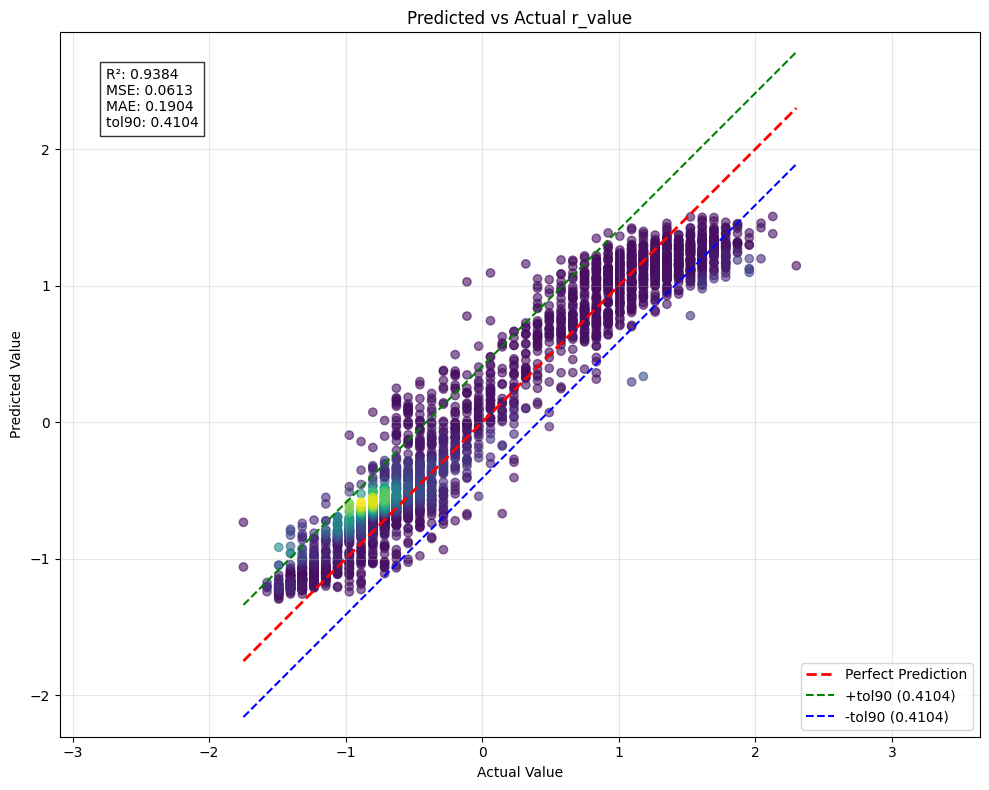

{'R2': 0.938367416262331,
 'MSE': 0.06132283384434343,
 'MAE': 0.19036765140436768,
 'tol90': 0.41037315625601994}

In [17]:
plot_predicted_vs_actual(best_mlp[0], test_scaled_df, features_dict=features_dict, model_type='pytorch_mlp')

Epoch [10/100], Loss: 0.1689
Epoch [20/100], Loss: 0.1550
Epoch [30/100], Loss: 0.1477
Epoch [40/100], Loss: 0.1398
Epoch [50/100], Loss: 0.1310
Epoch [60/100], Loss: 0.1248
Epoch [70/100], Loss: 0.1167
Epoch [80/100], Loss: 0.1111
Epoch [90/100], Loss: 0.1046
Epoch [100/100], Loss: 0.0978
Evaluation - Test Loss: 0.1591, R2: 0.9474


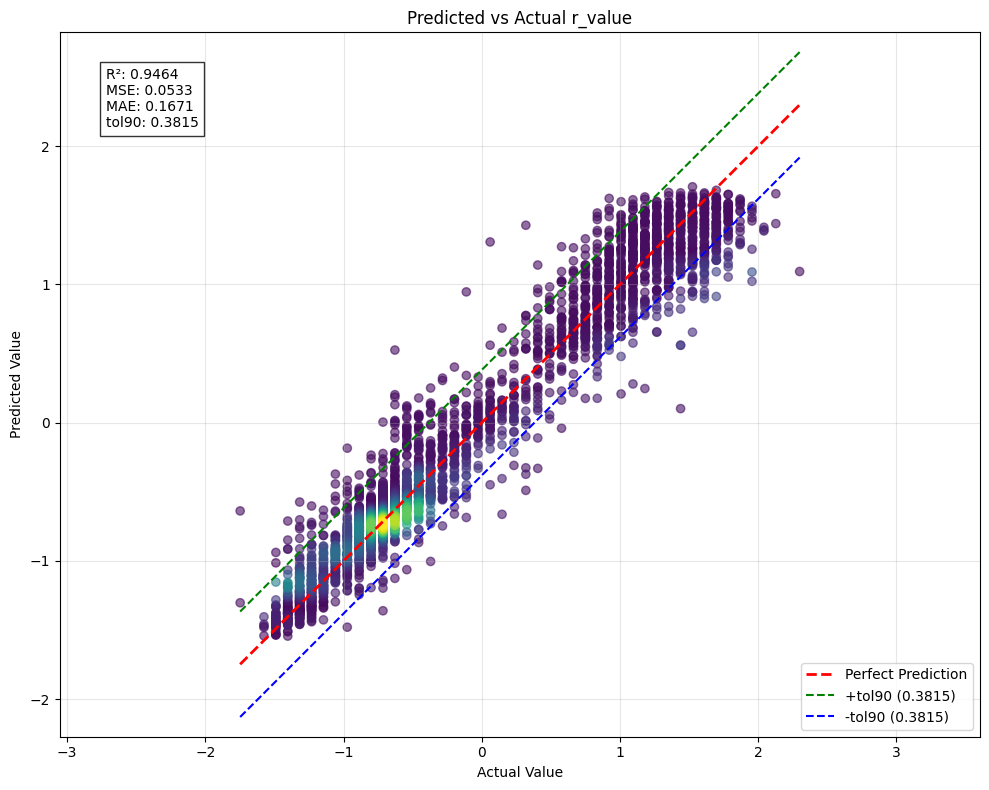

{'R2': 0.9463982096648362,
 'MSE': 0.05333240119339018,
 'MAE': 0.1670902336021059,
 'tol90': 0.38150371343787814}

In [18]:
best_params_grid = {'batch_size': 32,
 'cross_branch_dropout': 0,
 'dropout_rate': 0.2,
 'final_layer_dropout': [0, 0],
 'final_layer_units': [128, 64],
 'hidden_units': 64,
 'learning_rate': 0.001,
 'normalization': 'layer'}

best_mlp_enhanced = train_model_enhanced(train_scaled_df, features_dict, num_epochs, best_params_grid)
plot_predicted_vs_actual(best_mlp_enhanced[0], test_scaled_df, features_dict=features_dict, model_type='pytorch_mlp')

In [ ]:
import shap

def analyze_feature_importance(model, X, feature_names=None, max_samples=1000, top_n=5):
    """
    Compute SHAP values for Gaussian Process Regressor
    Uses KernelExplainer since GPR is not a tree-based model
    """
    print(f"Starting SHAP analysis for dataset of shape: {X.shape}")
    
    # Get feature names
    if feature_names is None and isinstance(X, pd.DataFrame):
        feature_names = list(X.columns)
    
    # Convert to numpy if needed
    if isinstance(X, pd.DataFrame):
        X = X.astype('float32').values
    else:
        X = np.array(X, dtype='float32')
    
    # Sample data if needed
    if len(X) > max_samples:
        print(f"Limiting to {max_samples} samples for faster computation")
        indices = np.random.RandomState(42).choice(len(X), max_samples, replace=False)
        X = X[indices]
    
    try:
        # Create background data for KernelExplainer
        background = shap.sample(X, 100)  # Sample 100 background points
        
        # Create explainer using KernelExplainer for GPR
        explainer = shap.KernelExplainer(model.predict, background)
        
        # Calculate SHAP values
        shap_values = explainer.shap_values(X)
        
        # Get mean absolute SHAP values
        feature_importance = np.abs(shap_values).mean(axis=0)
        
        # Create and sort importance dictionary
        importance_dict = dict(zip(feature_names, feature_importance))
        top_features = dict(sorted(importance_dict.items(), 
                                 key=lambda x: x[1], 
                                 reverse=True)[:top_n])
        
        return top_features
        
    except Exception as e:
        print(f"Error during SHAP analysis: {str(e)}")
        return None

In [ ]:
# top_features_rf = analyze_feature_importance(
#     model=model_info['model'],
#     X=test_scaled_df.drop(['r_value'], axis=1),
#     max_samples=1000,
#     top_n=5
# )

In [ ]:
# top_features_xgb = analyze_feature_importance(
#     model=trained_models_xgb['model'],
#     X=test_scaled_df.drop(['r_value'], axis=1),
#     max_samples=1000,
#     top_n=5
# )

In [ ]:
def analyze_feature_importance_keras(model, X, feature_names=None, max_samples=1000, top_n=5):
    """
    Compute SHAP values for Keras Sequential model using KernelExplainer
    """
    print(f"Starting SHAP analysis for dataset of shape: {X.shape}")
    
    # Get feature names
    if feature_names is None and isinstance(X, pd.DataFrame):
        feature_names = list(X.columns)
    
    # Convert to numpy and ensure float type
    if isinstance(X, pd.DataFrame):
        # Convert to float32 - handles numeric conversion
        X = X.astype('float32').values
    else:
        X = np.array(X, dtype='float32')
        
    # Sample data if needed
    if len(X) > max_samples:
        print(f"Limiting to {max_samples} samples for faster computation")
        indices = np.random.RandomState(42).choice(len(X), max_samples, replace=False)
        X = X[indices]
    
    try:
        # Create background data
        background = shap.sample(X, 100)
        
        # Create model prediction function
        def model_predict(x):
            return model.predict(x, verbose=0)
        
        # Create explainer
        explainer = shap.KernelExplainer(model_predict, background)
        
        # Calculate SHAP values
        shap_values = explainer.shap_values(X)
        
        # Handle different output formats
        if isinstance(shap_values, list):
            shap_values = shap_values[0]
            
        # Get mean absolute SHAP values
        feature_importance = np.abs(shap_values).mean(axis=0)
        
        # Create and sort importance dictionary
        importance_dict = dict(zip(feature_names, feature_importance))
        top_features = dict(sorted(importance_dict.items(), 
                                 key=lambda x: x[1], 
                                 reverse=True)[:top_n])
        
        return top_features
        
    except Exception as e:
        print(f"Error during SHAP analysis: {str(e)}")
        print("Full error:", traceback.format_exc())  # Add this for more detail
        return None

In [ ]:
# top_features = analyze_feature_importance_keras(
#     model=model_ann,
#     X=test_scaled_df.drop(['r_value'], axis=1),
#     max_samples=1000,
#     top_n=5
# )

In [ ]:
top_features_knn = analyze_feature_importance(
    model=trained_models_knn['model'],
    X=test_scaled_df.drop(['r_value'], axis=1),
    max_samples=1000,
    top_n=5
)
top_features_knn

In [ ]:
top_features_svr = analyze_feature_importance(
    model=trained_models_svr['model'],
    X=test_scaled_df.drop(['r_value'], axis=1),
    max_samples=1000,
    top_n=5
)
top_features_svr

In [ ]:
top_features_ridge = analyze_feature_importance(
    model=trained_models_ridge['model'],
    X=test_scaled_df.drop(['r_value'], axis=1),
    max_samples=1000,
    top_n=5
)
top_features_ridge

In [ ]:
top_features_gpr = analyze_feature_importance(
    model=trained_models_gpr['model'],
    X=test_scaled_df.drop(['r_value'], axis=1),
    max_samples=1000,
    top_n=5
)

In [ ]:
def analyze_nn_feature_importance(model, feature_dict, train_scaled_df, max_samples=1000, top_n=5):
    """
    Compute SHAP values for the multi-branch neural network model
    """
    print("Starting SHAP analysis for neural network")
    
    # Put model in eval mode
    model.eval()
    
    # Create a wrapper function for the model prediction
    def model_predict(X):
        # Split X into the different branches based on feature dimensions
        current_idx = 0
        branch_data = {}
        
        for category in ['chemical', 'time', 'process', 'model']:
            features = [f for f in feature_dict[category] if f in train_scaled_df.columns]
            if features:
                end_idx = current_idx + len(features)
                # Ensure data is float32
                branch_values = X[:, current_idx:end_idx].astype(np.float32)
                branch_data[category] = torch.FloatTensor(branch_values)
                current_idx = end_idx
            else:
                branch_data[category] = torch.zeros((X.shape[0], 0), dtype=torch.float32)
        
        # Make prediction
        with torch.no_grad():
            predictions = model(
                branch_data['chemical'],
                branch_data['time'],
                branch_data['process'],
                branch_data['model']
            )
        return predictions.numpy()

    # Prepare feature data
    feature_data = []
    feature_names = []
    
    # Combine features from all branches with explicit type conversion
    for category in ['chemical', 'time', 'process', 'model']:
        features = [f for f in feature_dict[category] if f in train_scaled_df.columns]
        if features:
            # Convert to numeric and handle any non-numeric values
            category_data = train_scaled_df[features].apply(pd.to_numeric, errors='coerce').fillna(0)
            feature_data.append(category_data.values.astype(np.float32))
            feature_names.extend(features)
    
    # Concatenate all features
    X = np.hstack(feature_data).astype(np.float32)
    
    print(f"Combined feature data shape: {X.shape}, dtype: {X.dtype}")
    
    # Sample data if needed
    if len(X) > max_samples:
        print(f"Limiting to {max_samples} samples for faster computation")
        indices = np.random.RandomState(42).choice(len(X), max_samples, replace=False)
        X = X[indices]
    
    try:
        # Create background data for KernelExplainer
        background = shap.sample(X, 100).astype(np.float32)  # Sample 100 background points
        print("Background data shape:", background.shape)
        
        # Create explainer
        explainer = shap.KernelExplainer(model_predict, background)
        
        # Calculate SHAP values
        shap_values = explainer.shap_values(X)
        
        # If shap_values is a list (multiple outputs), take the first element
        if isinstance(shap_values, list):
            shap_values = shap_values[0]
        
        # Get mean absolute SHAP values
        feature_importance = np.abs(shap_values).mean(axis=0)
        
        # Create and sort importance dictionary
        importance_dict = dict(zip(feature_names, feature_importance))
        top_features = dict(sorted(importance_dict.items(), 
                                 key=lambda x: x[1], 
                                 reverse=True)[:top_n])
        
        # Print top features and their importance scores
        print("\nTop feature importance scores:")
        for feat, score in top_features.items():
            print(f"{feat}: {score:.4f}")
        
        return top_features, shap_values, X, feature_names
        
    except Exception as e:
        print(f"Error during SHAP analysis: {str(e)}")
        import traceback
        traceback.print_exc()
        return None

def plot_shap_summary(shap_values, X, feature_names):
    """
    Create SHAP summary plot
    """
    try:
        shap.summary_plot(shap_values, X, feature_names=feature_names)
    except Exception as e:
        print(f"Error creating SHAP summary plot: {str(e)}")

In [ ]:
top_features, shap_values, X, feature_names = analyze_nn_feature_importance(
    best_mlp[0], 
    features_dict,
    test_scaled_df,
    max_samples=1000,
    top_n=10
)